# HRV & T2DM Capstone Project
## EDA & Data Analysis

January-March 2025 | Paul Kalnins, ND (kalninsp@ohsu.edu)


In [14]:
import os
import csv
import numpy as np
import pandas as pd
import math
import scipy
from tabulate import tabulate
import dataframe_image as dfi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, linregress, ttest_ind
from collections import defaultdict, Counter
from IPython.display import display, Markdown
import sklearn
import imblearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from scipy import stats
from tableone import TableOne
import plotly
import plotly.figure_factory as ff
import statsmodels

# Suppress FutureWarnings
#warnings.filterwarnings("ignore", category=FutureWarning)

# Check current working directory
print(os.getcwd())

# Test if the libraries are available
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("IMBLearn:", imblearn.__version__)
print("Sklearn:", sklearn.__version__)
print("Statsmodels:", statsmodels.__version__)
print(plotly.__version__)

/Users/pkalnins/Documents/Capstone/yr2_data/dataset
Numpy: 1.24.4
Pandas: 2.0.3
IMBLearn: 0.12.4
Sklearn: 1.3.2
Statsmodels: 0.14.1
6.0.1


***

## Exploratory Data Analysis

### Participant Characteristics/Summary Table

In [52]:
import pandas as pd
import os
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, fisher_exact, chi2_contingency

def create_summary_table(continuous_dict, categorical_dict, targets, hrv):
    output_path = "summary_results"
    data = pd.read_csv("extracted_data/filtered_data.csv")

    # Iterate over the target list
    for target in targets:
        # Create an empty list to store the summary data
        summary_data = []

        # Get counts for Low Risk and High Risk categories
        count_low_risk = len(data[data[target] == 0])
        count_high_risk = len(data[data[target] == 1])

        # Calculate the total number of samples
        total_samples = len(data)

        # Add the count row at the top of the table, including the total count
        summary_data.append({
            "Feature": f"Counts (Total n = {total_samples})",
            "Low Risk": f"{count_low_risk} ({(count_low_risk / total_samples * 100):.2f}%)",
            "High Risk": f"{count_high_risk} ({(count_high_risk / total_samples * 100):.2f}%)",
            "p-value": "", 
            "Test Used": ""
        })

        # Process continuous variables
        for var, label in continuous_dict.items():
            group_0 = data[data[target] == 0][var].dropna()
            group_1 = data[data[target] == 1][var].dropna()

            try:
                # Check normality and perform the appropriate test (Mann-Whitney U or t-test)
                _, p_normal_0 = shapiro(group_0)
                _, p_normal_1 = shapiro(group_1)

                if p_normal_0 < 0.05 or p_normal_1 < 0.05:
                    test_stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
                    test_used = "Mann-Whitney U"
                else:
                    test_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)
                    test_used = "t-test"

                mean_0, std_0 = group_0.mean(), group_0.std()
                mean_1, std_1 = group_1.mean(), group_1.std()

                summary_data.append({
                    "Feature": label,
                    "Low Risk": f"{mean_0:.2f} ({std_0:.2f})",
                    "High Risk": f"{mean_1:.2f} ({std_1:.2f})",
                    "p-value": f"<0.001" if p_value < 0.001 else f"{p_value:.3f}", 
                    "Test Used": test_used
                })
            except ValueError as e:
                print(f"Skipping variable {var} due to error: {e}")

        # Process categorical variables
        for var, label in categorical_dict.items():
            group_0 = data[data[target] == 0][var].dropna()
            group_1 = data[data[target] == 1][var].dropna()

            # Perform Chi-square or Fisher's Exact Test
            contingency_table = pd.crosstab(data[target], data[var])

            if contingency_table.empty or contingency_table.shape[1] < 2:
                print(f"Skipping '{var}' due to insufficient data for contingency table.")
                continue

            if (contingency_table.values < 5).any() and contingency_table.shape == (2, 2):
                _, p_value = fisher_exact(contingency_table)
                test_used = "Fisher's Exact"
            else:
                _, p_value, _, _ = chi2_contingency(contingency_table)
                test_used = "Chi-square"

            count_0 = group_0.sum()
            count_1 = group_1.sum()
            total_0 = len(group_0)
            total_1 = len(group_1)

            summary_data.append({
                "Feature": label,
                "Low Risk": f"{int(count_0)} ({(count_0 / total_0 * 100):.2f}%)",
                "High Risk": f"{int(count_1)} ({(count_1 / total_1 * 100):.2f}%)",
                "p-value": f"<0.001" if p_value < 0.001 else f"{p_value:.3f}", 
                "Test Used": test_used
            })

        # Create a DataFrame from the summary data
        summary_df = pd.DataFrame(summary_data)

        # Ensure the output directory exists
        os.makedirs(output_path, exist_ok=True)

        # Save the summary table as a CSV file
        summary_file = os.path.join(output_path, f"summary_table_{target}.csv")
        summary_df.to_csv(summary_file, index=False)

        print(f"Summary table for '{target}' saved to: {summary_file}")

    return summary_df



In [53]:
# Define your predictor and target dictionaries
continuous_dict = {
    "age": "Age (years)",
    "BMI": "BMI (kg/m²)",
    "WHR": "Waist-Hip Ratio",
    "waist_circum(cm)": "Waist Circumference (cm)", 
    "SBP": "Systolic BP (mmHg)",
    "DBP": "Diastolic BP (mmHg)",
    "glucose": "Glucose (mg/dL)",
    "hba1c": "Hemoglobin A1c (%)",
    "insulin": "Insulin (ng/mL)",
    "hs_crp": "hsCRP (mg/L)",
    "Tchol": "Total Cholesterol (mg/dL)",
    "TG": "Triglycerides (mg/dL)",
    "HDL": "HDL-Cholesterol (mg/dL)",
    "LDL": "LDL-Cholesterol (mg/dL)",
    "nt_probnp": "NT-proBNP (pg/mL)",
    "BUN": "Blood-Urea Nitrogen (mg/dL)",
    "creatinine": "Creatinine (mg/dL)",
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient (PRQ)",
    "SER": "Sleep Efficiency Ratio (SER) (%)",
    "cSDNN": "SDNN (Log-Normalized)",
    "cRMSSD": "RMSSD (Log-Normalized)",
    "SAFE": "SAFE Score"
}

categorical_dict = {
    "obesity": "Obesity",
    "MetS_cat": "Metabolic Syndrome",
    "HTN": "Hypertension", 
    "T2DM": "Type 2 Diabetes",
    "use_insulin": "Insulin Use",
    "SAFE_cat": "SAFE Category"
}


targets = ['T2DM', 'SAFE_cat']
summary_table = create_summary_table(continuous_dict, categorical_dict, targets, hrv=150)
print(summary_table)




Summary table for 'T2DM' saved to: summary_results/summary_table_T2DM.csv
Summary table for 'SAFE_cat' saved to: summary_results/summary_table_SAFE_cat.csv
                             Feature          Low Risk        High Risk  \
0             Counts (Total n = 740)      377 (50.95%)     363 (49.05%)   
1                        Age (years)      56.23 (9.95)    64.26 (10.36)   
2                        BMI (kg/m²)      28.05 (6.34)     33.39 (8.30)   
3                    Waist-Hip Ratio       0.89 (0.09)      0.94 (0.09)   
4           Waist Circumference (cm)     94.14 (15.57)   108.85 (16.50)   
5                 Systolic BP (mmHg)    125.03 (14.86)   131.90 (16.33)   
6                Diastolic BP (mmHg)      76.39 (8.88)     77.21 (9.28)   
7                    Glucose (mg/dL)     99.28 (32.03)   116.11 (52.20)   
8                 Hemoglobin A1c (%)       5.78 (0.89)      6.35 (1.18)   
9                    Insulin (ng/mL)       0.82 (0.90)      1.16 (1.25)   
10                 

***

### Missing Values

In [20]:
def create_missing_summary_table(file_path, col_dict, output_path="summary_table.csv"):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        "Variable Name": [col_dict[col] for col in col_dict.keys()],
        "Total Entries": [df[col].notnull().sum() for col in col_dict.keys()],
        "Missing Values": [df[col].isnull().sum() for col in col_dict.keys()]
    })
    
    # Print the table in Jupyter Notebook
    print(summary_df.to_string(index=False))
    
    summary_df.to_csv(output_path, index=False)

    print(f"Table saved as '{output_path}'.")



In [21]:
# Example usage
col_dict = {
    "age": "Age (years)",
    "BMI": "Body Mass Index (kg/m²)",
    "WHR": "Waist-Hip Ratio", 
    "SBP": "Systolic Blood Pressure", 
    "DBP": "Diastolic Blood Pressure", 
    "hba1c": "Hemoglobin A1c (%)",
    "hs_crp": "High-Sensitivity CRP (mg/L)",
    "Tchol": "Total Cholesterol (mg/dL)", 
    "TG": "Triglyderides (mg/dL)", 
    "HDL": "HDL-C (mg/dL)", 
    "LDL": "LDL-C (mg/dL)", 
    "BUN": "BUN (mg/dL)", 
    "creatinine": "creatinine (mg/dL)", 
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient",
    "SER": "Sleep Efficiency Ratio",
    "cSDNN": "Log-Normalized SDNN",
    "cRMSSD": "Log-Normalized RMSSD"
}

# Call the function
create_missing_summary_table("extracted_data/filtered_data.csv", col_dict, "summary_table_after.csv")

              Variable Name  Total Entries  Missing Values
                Age (years)            740               0
    Body Mass Index (kg/m²)            740               0
            Waist-Hip Ratio            740               0
    Systolic Blood Pressure            740               0
   Diastolic Blood Pressure            740               0
         Hemoglobin A1c (%)            734               6
High-Sensitivity CRP (mg/L)            740               0
  Total Cholesterol (mg/dL)            740               0
      Triglyderides (mg/dL)            740               0
              HDL-C (mg/dL)            740               0
              LDL-C (mg/dL)            740               0
                BUN (mg/dL)            740               0
         creatinine (mg/dL)            740               0
        Garmin Stress Score            740               0
 Pulse-Respiratory Quotient            740               0
     Sleep Efficiency Ratio            740              

***

### Feature Distributions

In [55]:
import pandas as pd
from scipy import stats

def create_distribution_table(predictor_dict):
    output_file="womaf_summary.csv"
    data =  data = pd.read_csv("extracted_data/filtered_data.csv")
    
    summary_data = []

    # Loop through each predictor in the dictionary
    for var, label in predictor_dict.items():
        # Drop NaN values for analysis
        valid_data = data[var].dropna()
        
        # Calculate missing values
        missing_n = data[var].isnull().sum()
        
        # Calculate min and max
        min_value = valid_data.min()
        max_value = valid_data.max()
        
        # Perform Shapiro-Wilk test
        if len(valid_data) > 3:  # Shapiro-Wilk requires at least 3 samples
            stat, p_value = stats.shapiro(valid_data)
        else:
            stat, p_value = None, None
        
        # Determine if the variable is normally distributed
        normal_dist = "Yes" if p_value and p_value > 0.05 else "No"
        
        # Append results to the summary list
        summary_data.append({
            "Predictor": label,
            "Missing (n)": missing_n,
            "Minimum": f"{min_value:.2f}" if pd.notnull(min_value) else "NA",
            "Maximum": f"{max_value:.2f}" if pd.notnull(max_value) else "NA",
            "Shapiro-Wilk p-value": f"{p_value:.4f}" if p_value is not None else "NA",
            "Normal Distribution": normal_dist
        })

    # Create a DataFrame from the summary data
    summary_df = pd.DataFrame(summary_data)
    
    # Save the summary to a CSV file
    summary_df.to_csv(output_file, index=False)
    
    print(f"Summary table saved to '{output_file}' successfully.")


In [56]:
# Define predictor dictionary
feature_dict = {
    "BMI": "Body Mass Index (kg/m2)", 
    "WHR": "Waist Hip Ratio", 
    "waist_circum(cm)": "Waist Circumference (cm)",
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient (PRQ)",
    "SER": "Sleep Efficiency Ratio (SER)",
    "cSDNN": "SDNN (Log-Normalized)",
    "cRMSSD": "RMSSD (Log-Normalized)", 
    "hba1c": "Hemoglobin A1c",  
    "SAFE": "SAFE Score"
}

# Create the summary table
create_distribution_table(feature_dict)


Summary table saved to 'womaf_summary.csv' successfully.


In [59]:
def plot_histograms(variables_map):
    
    df = data = pd.read_csv("extracted_data/filtered_data.csv")
    
    # Extract the master plot title and variable rename map from the input
    master_title = variables_map.get("master_title", "Distributions of Feature Variables")
    variable_rename_map = {key: value for key, value in variables_map.items() if key != "master_title"}

    # Rename variables using the map
    renamed_variables = [variable_rename_map.get(var, var) for var in variable_rename_map.keys()]
    
    # Clean the data by dropping missing values
    data_cleaned = df[list(variable_rename_map.keys())].dropna()
    num_observations = len(data_cleaned)
    print(f"Total number of final observations: {num_observations}")

    # Calculate min and max ranges
    ranges = {}
    for variable in variable_rename_map.keys():
        if variable in data_cleaned:
            min_val = data_cleaned[variable].min()
            max_val = data_cleaned[variable].max()
            ranges[variable] = (min_val, max_val)

    print("Ranges:")
    for variable, (min_val, max_val) in ranges.items():
        print(f"{variable}: Min = {min_val}, Max = {max_val}")

    # Set Seaborn style
    sns.set(style="whitegrid")
    
    num_vars = len(variable_rename_map)
    cols = 4  # 3 plots per row
    rows = math.ceil(num_vars / cols)  # Calculate number of rows needed

    plt.figure(figsize=(5 * cols, 4 * rows))  # Adjust figure size dynamically

    # Plot each variable's distribution
    for i, (var, renamed_var) in enumerate(zip(variable_rename_map.keys(), renamed_variables), 1):
        plt.subplot(rows, cols, i)
        sns.histplot(data_cleaned[var], kde=True, bins=30, color='blue')
        plt.xlabel(renamed_var)
        plt.ylabel("Frequency")


    # Adjust layout and display plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust for the master title
    plt.show()




Total number of final observations: 734
Ranges:
BMI: Min = 17.881, Max = 74.531
WHR: Min = 0.369, Max = 1.792
waist_circum(cm): Min = 41.0, Max = 190.0
stress_gv5: Min = 15.38, Max = 94.95
PRQ_gv5: Min = 3.44, Max = 7.52
SER: Min = 32.32, Max = 99.42
cSDNN: Min = -3.97, Max = 0.59
cRMSSD: Min = -4.0, Max = 0.8
hba1c: Min = 3.8, Max = 13.9
SAFE: Min = -277.08, Max = 382.86


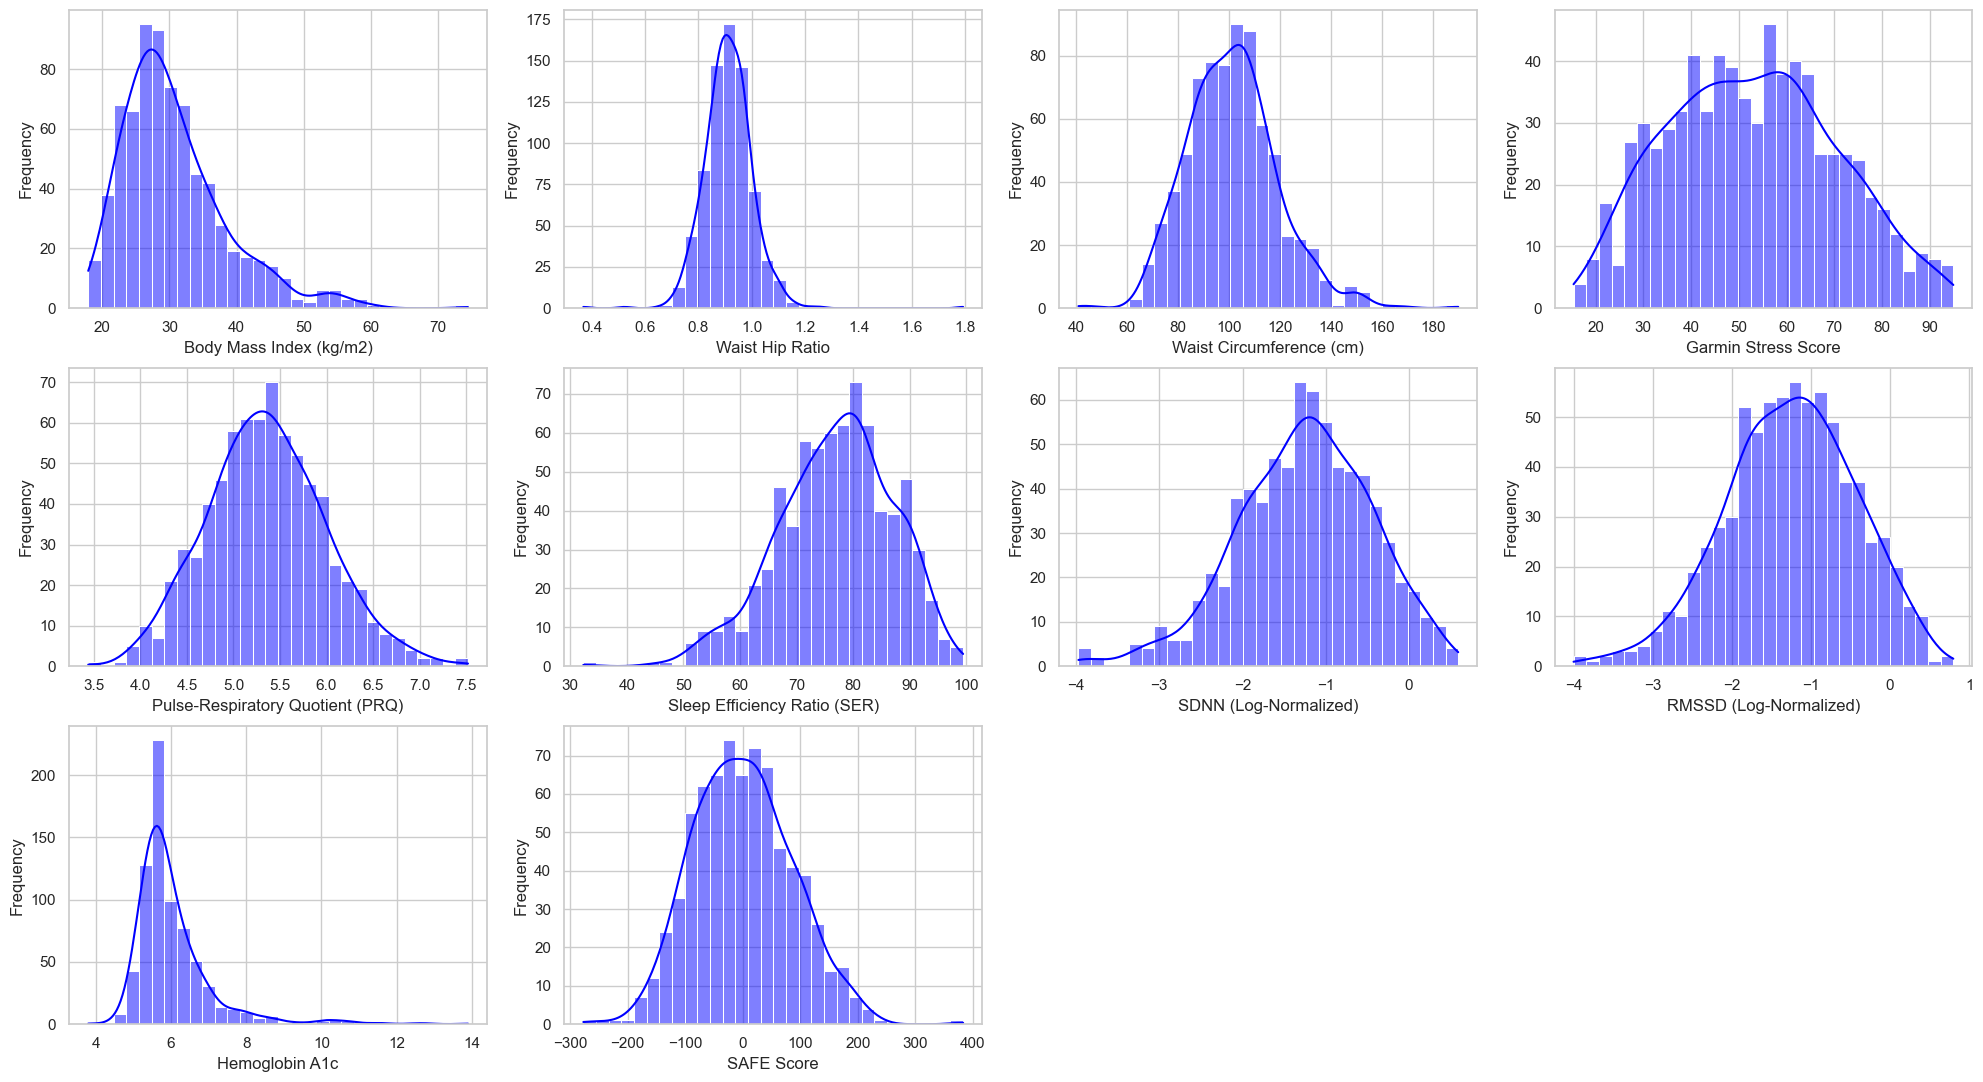

In [60]:
features_map = {
    "master_title": "Distributions of Variables",
    
    "BMI": "Body Mass Index (kg/m2)", 
    "WHR": "Waist Hip Ratio", 
    "waist_circum(cm)": "Waist Circumference (cm)",
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient (PRQ)",
    "SER": "Sleep Efficiency Ratio (SER)",
    "cSDNN": "SDNN (Log-Normalized)",
    "cRMSSD": "RMSSD (Log-Normalized)", 
    "hba1c": "Hemoglobin A1c",  
    "SAFE": "SAFE Score"
}

plot_histograms(features_map)

### Correlation Heatmap

In [61]:
def create_correlation_heatmap(variables):
    data = pd.read_csv("extracted_data/filtered_data.csv") 
    data_subset = data[variables]
    correlation_matrix = data_subset.corr()

    plt.figure(figsize=(10, 8))
    
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        fmt='.2f', 
        cmap='coolwarm', 
        linewidths=0.5, 
        vmin=-1, vmax=1, 
        annot_kws={'size': 6}  
    )

    plt.title("Correlation Heatmap")
    plt.show()


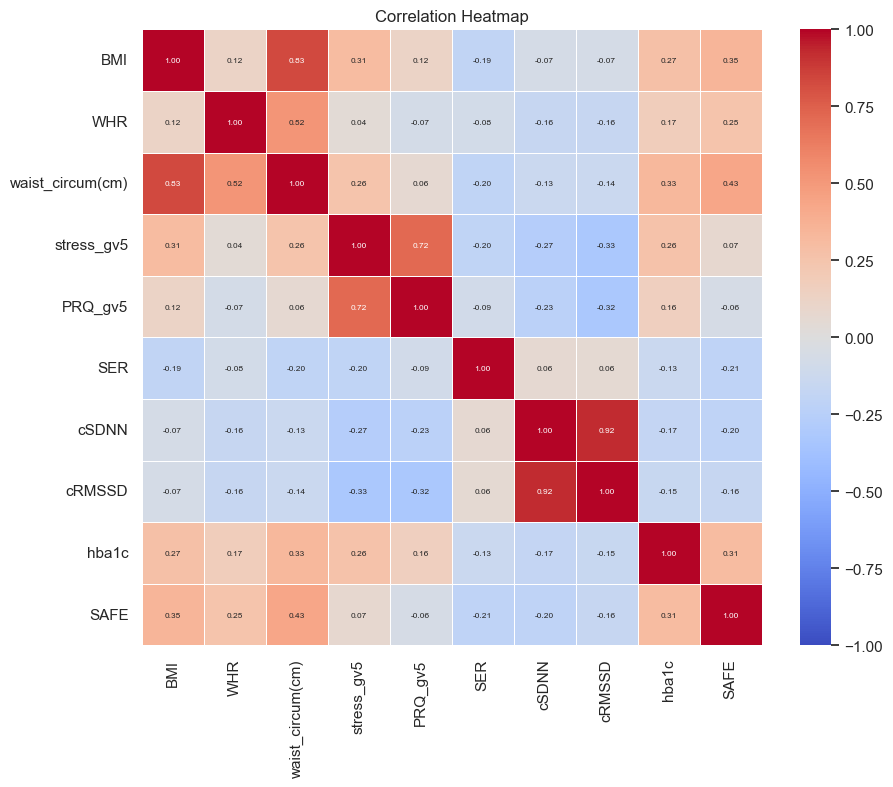

In [62]:
variables = [ 
    "BMI", "WHR", "waist_circum(cm)", 
    "stress_gv5", "PRQ_gv5", "SER",  
    "cSDNN", "cRMSSD",  
    "hba1c", 
    "SAFE"
]


create_correlation_heatmap(variables)

***

### Determine Normality of WOMAFs


In [30]:
import pandas as pd
from scipy import stats

# Load the data
data = pd.read_csv("extracted_data/filtered_data.csv") 

# List of WOMAFs to check for normality
womafs = ['stress_gv5', 'PRQ_gv5', 'SER', 'cSDNN', 'cRMSSD']

# Perform Shapiro-Wilk test for each WOMAF
for var in womafs:
    stat, p_value = stats.shapiro(data[var].dropna())  # dropna to avoid NaNs
    print(f"\n{var} - Shapiro-Wilk Test statistic: {stat:.4f}, p-value: {p_value:.4f}")
    
    if p_value > 0.05:
        print(f"{var} is likely normally distributed (p > 0.05)")
    else:
        print(f"{var} is likely not normally distributed (p <= 0.05)")



stress_gv5 - Shapiro-Wilk Test statistic: 0.9875, p-value: 0.0000
stress_gv5 is likely not normally distributed (p <= 0.05)

PRQ_gv5 - Shapiro-Wilk Test statistic: 0.9969, p-value: 0.1720
PRQ_gv5 is likely normally distributed (p > 0.05)

SER - Shapiro-Wilk Test statistic: 0.9866, p-value: 0.0000
SER is likely not normally distributed (p <= 0.05)

cSDNN - Shapiro-Wilk Test statistic: 0.9895, p-value: 0.0000
cSDNN is likely not normally distributed (p <= 0.05)

cRMSSD - Shapiro-Wilk Test statistic: 0.9941, p-value: 0.0055
cRMSSD is likely not normally distributed (p <= 0.05)


### Boxplots of Predictors By Target

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_boxplots_2(predictor_dict, target):
    df = pd.read_csv("extracted_data/filtered_data.csv") 

    # Ensure the target column is binary and has no NaN values
    df = df.dropna(subset=[target])
    df[target] = df[target].astype(int)

    # Set Seaborn theme for aesthetics
    sns.set_theme(style="whitegrid")

    # Get the predictor names and display names from the dictionary
    predictors = list(predictor_dict.keys())
    
    # Determine the number of rows needed for a 3-column grid
    num_plots = len(predictors)
    num_cols = 3
    num_rows = math.ceil(num_plots / num_cols)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    axes = axes.flatten()  # Flatten to 1D array for easier indexing

    # Define a color palette for the target
    palette = {0: "#3498db", 1: "#e74c3c"}  # Blue for 0, Red for 1

    # Loop through each predictor and create a boxplot
    for i, predictor in enumerate(predictors):
        if predictor in df.columns:
            sns.boxplot(
                x=target,
                y=predictor,
                data=df,
                ax=axes[i],
                hue=target,
                palette=palette,
                width=0.6,
                linewidth=1.5,
                dodge=False,
                flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'),
                legend=False  # Remove the legend
            )

            # Set the title using the display name and align it to the left
            #axes[i].set_title(predictor_dict[predictor], fontsize=16, fontweight="bold", loc='left')
            axes[i].set_ylabel("")  
            axes[i].set_xlabel("")

            # Improve aesthetics
            axes[i].grid(axis='y', linestyle="--", alpha=0.7)
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
        else:
            axes[i].set_visible(False)  # Hide empty plots if predictor is missing

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    # Add master title to the figure, aligned to the left
    #plt.suptitle(f"Predictor Distributions by {target}", fontsize=20, fontweight="bold", ha='left', x=0.01)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


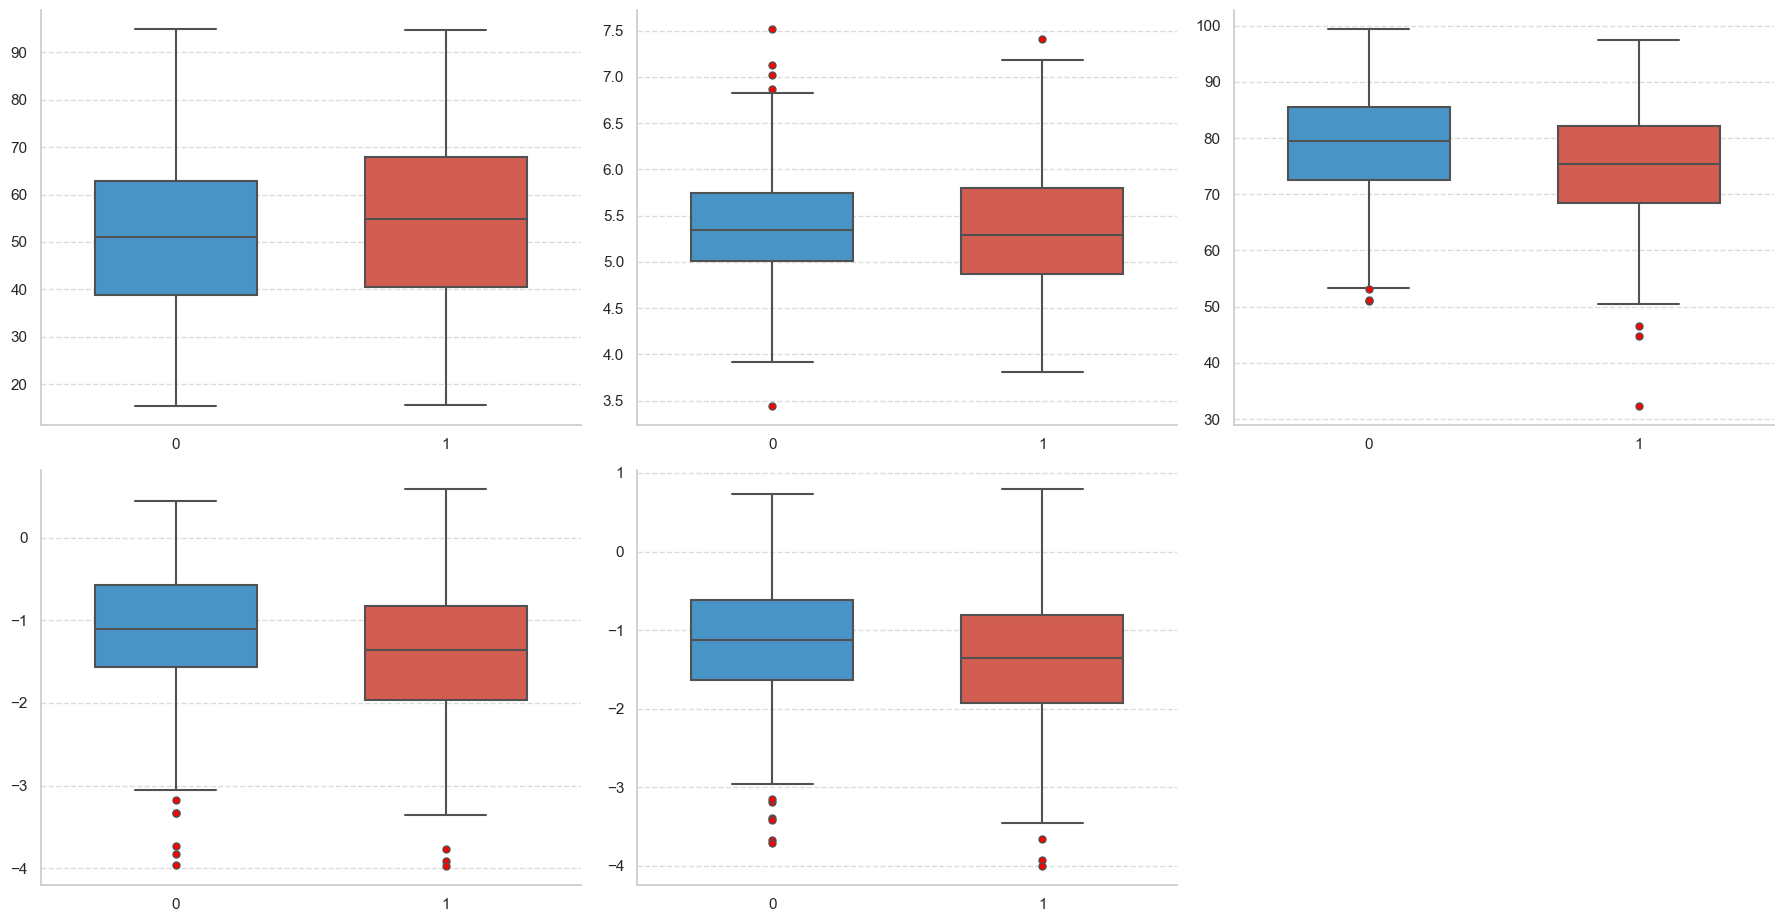

In [35]:
predictor_dict = {
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient",
    "SER": "Sleep Efficiency Ratio (%)",
    "cSDNN": "SDNN (log normalized)",
    "cRMSSD": "RMSSD (log normalized)"
}

target = "SAFE_cat"

plot_boxplots_2(predictor_dict, target)


In [37]:
predictors = [ 
    "stress_gv5", "PRQ_gv5", "SER", 
    "cSDNN", "cRMSSD"
]

target = "SAFE_cat"

plot_boxplots_2(predictors, target)

AttributeError: 'list' object has no attribute 'keys'

### Linear Regression

In [63]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def run_multivariable_regression(predictors, target, hrv):
    # Load the dataset
    df = pd.read_csv("extracted_data/filtered_data.csv") 
    
    # Ensure predictors and target exist in the dataset
    missing_cols = [col for col in predictors + [target] if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Columns not found in dataset: {missing_cols}")

    # Drop rows with missing values in the selected columns
    df = df[predictors + [target]].dropna()

    # Get the final sample size
    total_samples = len(df)

    # Define predictor (X) and target (y) variables
    X = df[predictors]
    y = df[target]

    # Add constant term for intercept in statsmodels
    X_const = sm.add_constant(X)

    # Fit model using statsmodels (for inference)
    model_sm = sm.OLS(y, X_const).fit()

    # Fit model using sklearn (for performance metrics)
    model_sklearn = LinearRegression()
    model_sklearn.fit(X, y)
    y_pred = model_sklearn.predict(X)

    # Compute performance metrics
    r2 = round(model_sklearn.score(X, y), 2)
    mse = round(mean_squared_error(y, y_pred), 2)
    rmse = round(np.sqrt(mse), 2)
    n = len(y)
    p = len(predictors)
    adj_r2 = round(1 - (1 - r2) * (n - 1) / (n - p - 1), 2)

    # Format model coefficients, p-values, and confidence intervals to 2 decimal places
    coef = model_sm.params.round(2)
    p_values = model_sm.pvalues.round(5)
    conf_int = model_sm.conf_int().round(2)

    # Generate report
    report = f"""
    Multivariable Linear Regression Report
    ---------------------------------------
    Total Samples Used: {total_samples}

    Target Variable: {target}
    Predictors: {', '.join(predictors)}

    Model Coefficients:
    {coef.to_string()}

    R-squared: {r2}
    Adjusted R-squared: {adj_r2}
    Mean Squared Error (MSE): {mse}
    Root Mean Squared Error (RMSE): {rmse}

    Statistical Significance (p-values):
    {p_values.to_string()}

    Confidence Intervals (95%):
    {conf_int.to_string()}
    """

    print(report)
    return model_sm



In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math

def plot_multiple_regressions(predictor_dict, target, hrv):
    """
    Plots multiple linear regression graphs for predictors with the target variable.
    
    Args:
    - predictor_dict (dict): Dictionary with predictor names as keys (column names) 
                              and display names as values (plot titles).
    - target (str): Name of the target variable/column in the dataset.

    Returns:
    - models (dict): Dictionary of fitted models for each predictor.
    """

    # Load data
    df = pd.read_csv("extracted_data/filtered_data.csv") 

    # Get predictor column names from the dictionary keys
    predictors = list(predictor_dict.keys())

    # Drop missing values for selected columns
    df = df[predictors + [target]].dropna()

    # Set up dynamic grid layout
    num_predictors = len(predictors)
    num_cols = 3  # 3 plots per row
    num_rows = math.ceil(num_predictors / num_cols)

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten in case of a single row

    models = {}  # Store models for each predictor

    for i, predictor in enumerate(predictors):
        ax = axes[i]  # Select the current subplot

        # Extract predictor and target data
        X = df[predictor].values
        y = df[target].values

        # Fit a linear regression model
        X_with_const = sm.add_constant(X)
        model = sm.OLS(y, X_with_const).fit()
        y_pred = model.predict(X_with_const)

        # Get R² value
        r_squared = model.rsquared

        # Scatter plot
        sns.scatterplot(x=X, y=y, ax=ax, alpha=0.7, label="Data points")

        # Regression line
        ax.plot(X, y_pred, color="red", label="Regression line")

        # Confidence interval
        pred_summary = model.get_prediction(X_with_const).summary_frame(alpha=0.05)
        ax.fill_between(X, pred_summary["obs_ci_lower"], pred_summary["obs_ci_upper"], color='gray', alpha=0.2, label="95% CI")

        # Update plot titles with left-centered names from the data dictionary
        title_text = f"{predictor_dict[predictor]} vs. {target}"
        ax.set_title(title_text, loc="left", fontsize=12, fontweight="bold")

        # Remove x and y axis labels
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Display R² value in the top-left corner
        ax.text(
            0.05, 0.9, f"$R^2 = {r_squared:.3f}$",
            transform=ax.transAxes, fontsize=12,
            color="black", bbox=dict(facecolor='white', alpha=0.5)
        )

        # Set legend consistently to top-right for all graphs
        ax.legend(loc="upper right")

        ax.grid(True)

        # Store the fitted model
        models[predictor] = model

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return models  # Return all fitted models



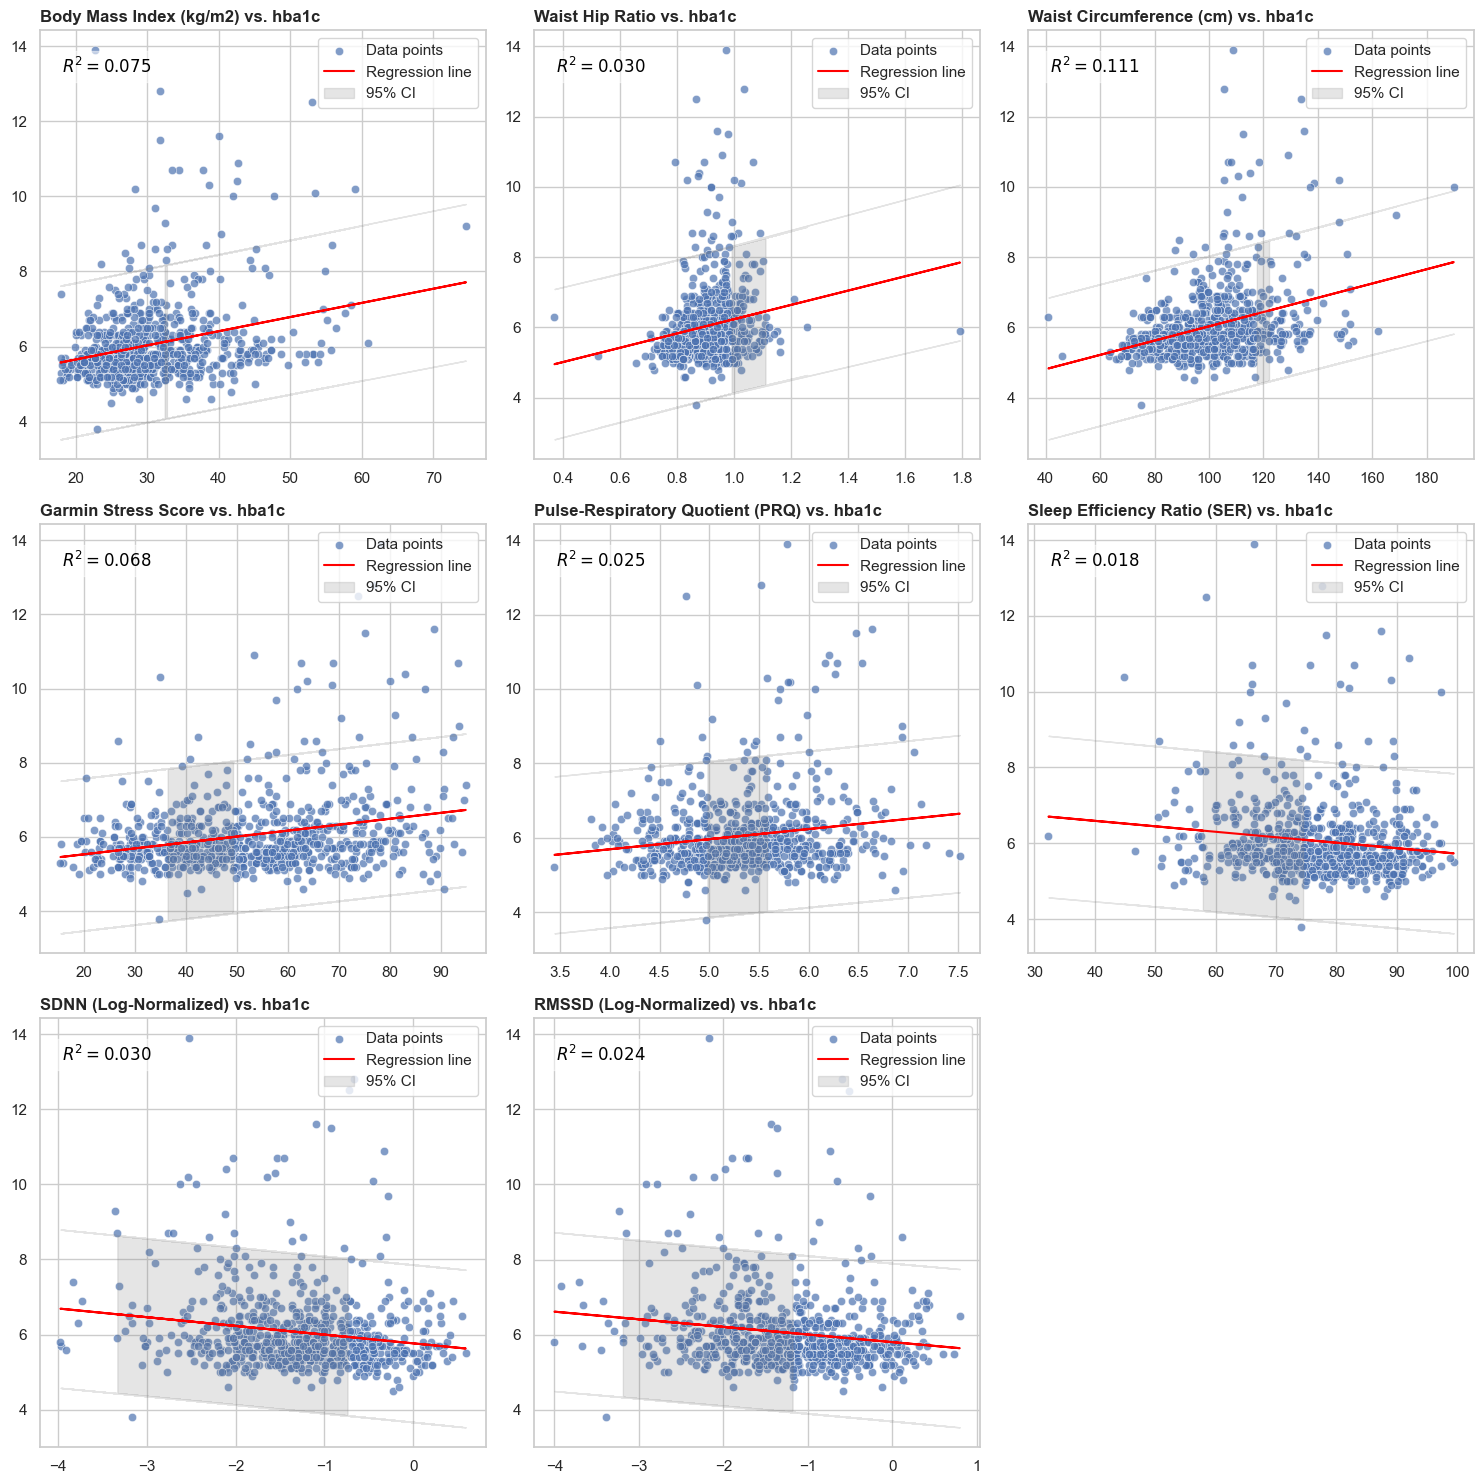

In [65]:
# Define the data dictionary
womafs_dict = {
    "BMI": "Body Mass Index (kg/m2)", 
    "WHR": "Waist Hip Ratio", 
    "waist_circum(cm)": "Waist Circumference (cm)",
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient (PRQ)",
    "SER": "Sleep Efficiency Ratio (SER)",
    "cSDNN": "SDNN (Log-Normalized)",
    "cRMSSD": "RMSSD (Log-Normalized)"
}

# Define target variable
target_variable = "hba1c"  # Or your target variable name

# Run the function with the dictionary and target variable
models = plot_multiple_regressions(womafs_dict, target_variable, hrv=150)


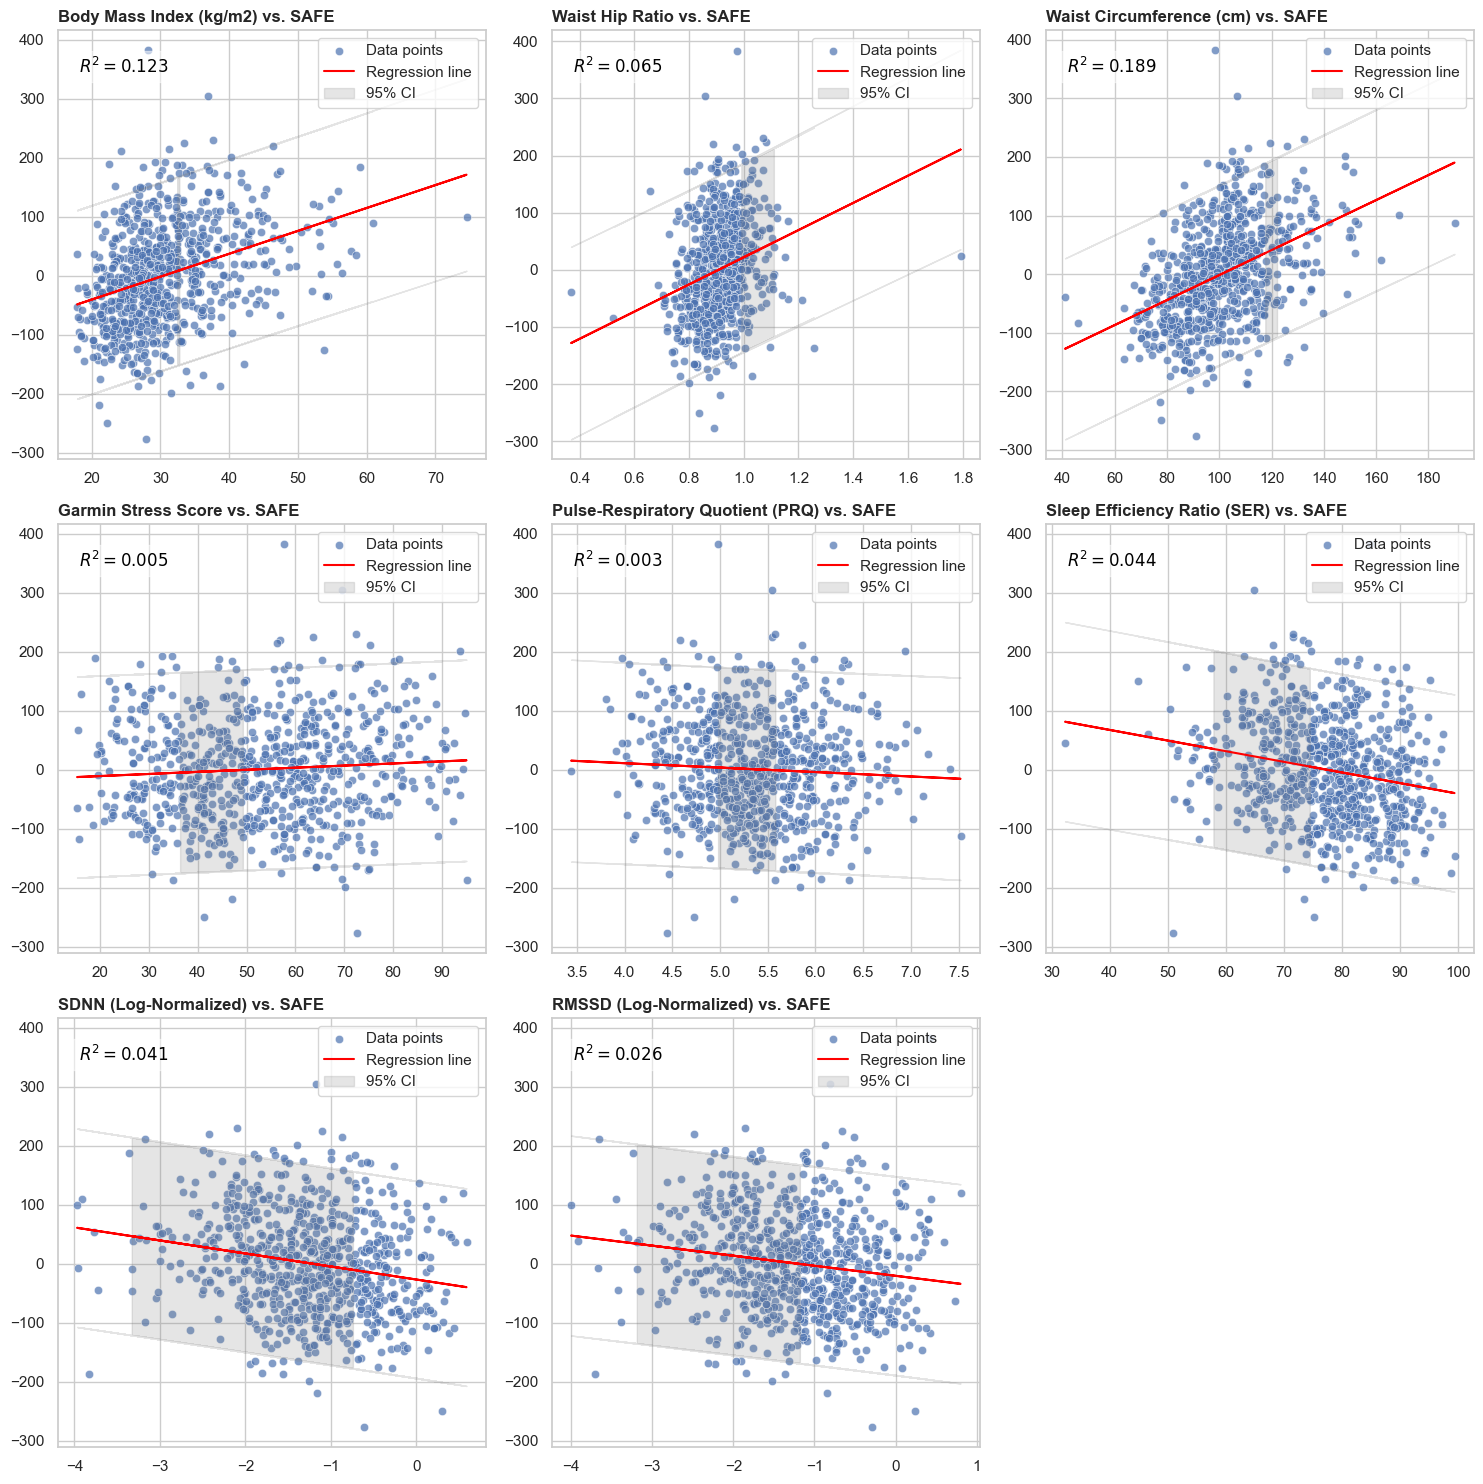

In [66]:
# Define the data dictionary
womafs_dict = {
    "BMI": "Body Mass Index (kg/m2)", 
    "WHR": "Waist Hip Ratio", 
    "waist_circum(cm)": "Waist Circumference (cm)",
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient (PRQ)",
    "SER": "Sleep Efficiency Ratio (SER)",
    "cSDNN": "SDNN (Log-Normalized)",
    "cRMSSD": "RMSSD (Log-Normalized)"
}

# Define target variable
target_variable = "SAFE"  # Or your target variable name

# Run the function with the dictionary and target variable
models = plot_multiple_regressions(womafs_dict, target_variable, hrv=150)

***

### Logistic Regression (ML Models)

### Run Statistical Regression

In [67]:
def logistic_regression_summary(predictor_dict, target_dict, hrv):
    """
    Fits a logistic regression model, prints model summary and performance, and saves results to CSV.

    Args:
    - predictor_dict (dict): Dictionary with predictor names as keys (column names) 
                              and display names as values (table and plot titles).
    - target_dict (dict): Dictionary with target variable name as key and display name as value.
    - hrv (DataFrame): Input dataset after filtering.

    Returns:
    - models (dict): Dictionary of fitted logistic regression models for each target.
    """

    df = pd.read_csv("extracted_data/filtered_data.csv") 
    output_dir = "regression_results"
    
    # Create output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get predictor column names and prepare for model fitting
    predictors = list(predictor_dict.keys())

    # Dictionary to store models for each target
    models = {}

    # Loop through all targets dynamically
    for target_var, target_name in target_dict.items():
        # Drop rows with missing values for predictors and target
        df_filtered = df[predictors + [target_var]].dropna()

        # Prepare data for logistic regression
        X = df_filtered[predictors]
        X = sm.add_constant(X)  # Add constant for intercept
        y = df_filtered[target_var]

        # Fit logistic regression model
        model = sm.Logit(y, X).fit(disp=False)
        models[target_var] = model

        # Print model title
        print(f"\n{target_name} Logistic Regression Model\n" + "=" * 40)
        
        # Sample size and class distribution
        total_samples = int(len(df_filtered))  # Ensuring integer
        class_counts = y.value_counts().sort_index().astype(int).to_dict()

        # Calculate McFadden's R²
        mcfadden_r2 = 1 - (model.llf / model.llnull)

        # Extract model coefficients
        coef_summary = model.summary2().tables[1].reset_index()
        coef_summary.columns = ["Predictor", "Coefficient", "Std. Err.", "z", "p-value", "[0.025", "0.975]"]

        # Calculate Odds Ratio and 95% CI manually
        coef_summary["Odds Ratio"] = np.exp(coef_summary["Coefficient"])
        coef_summary["CI Lower"] = np.exp(coef_summary["Coefficient"] - 1.96 * coef_summary["Std. Err."])
        coef_summary["CI Upper"] = np.exp(coef_summary["Coefficient"] + 1.96 * coef_summary["Std. Err."])
        
        # ✅ Format 95% CI as [x, y]
        coef_summary["95% CI"] = coef_summary.apply(
            lambda row: f"[{row['CI Lower']:.2f}, {row['CI Upper']:.2f}]", axis=1
        )

        # Round Odds Ratio to 3 decimal places
        coef_summary["Odds Ratio"] = coef_summary["Odds Ratio"].round(3)

        # Format p-value with 3 decimal places and handle < 0.001
        coef_summary["p-value"] = coef_summary["p-value"].apply(
            lambda p: "< 0.001" if p < 0.001 else f"{p:.3f}"
        )

        # Rename predictors using the data dictionary
        coef_summary["Predictor"] = coef_summary["Predictor"].replace(predictor_dict).replace({"const": "Intercept"})

        # Calculate percentage of total samples for each class count
        class_0_percent = (class_counts.get(0, 0) / total_samples) * 100
        class_1_percent = (class_counts.get(1, 0) / total_samples) * 100
        
        # Create a new column for "Class Count / Total Samples"
        result_table = coef_summary[["Predictor", "95% CI", "p-value", "Odds Ratio"]]  # Reordered columns

        # Add rows for Total Samples and Class Counts, and leave "Odds Ratio" empty for them
        summary_rows = pd.DataFrame({
            "Predictor": ["Total Samples", "Class 0 Count", "Class 1 Count"],
            "Counts": [
                f"{total_samples}",
                f"{class_counts.get(0, 0)} ({class_0_percent:.0f}%)",
                f"{class_counts.get(1, 0)} ({class_1_percent:.0f}%)"
            ], 
            "Odds Ratio": ["", "", ""],  
            "95% CI": ["-", "-", "-"],
            "p-value": ["-", "-", "-"]
        })
        
        # Concatenate the summary rows with the result table
        result_table = pd.concat([summary_rows, result_table], ignore_index=True)

        # Add McFadden's R² row to the table
        mcfadden_row = pd.DataFrame({
            "Predictor": ["McFadden's R²"],
            "Counts": [f"{mcfadden_r2:.3f}"],
            "Odds Ratio": ["-"],
            "95% CI": ["-"],
            "p-value": ["-"]
        })
        
        # Append McFadden's R² to the result table
        result_table = pd.concat([result_table, mcfadden_row], ignore_index=True)

        # Print regression table
        print(result_table.to_string(index=False))
        

        # Save table as CSV in the output directory
        csv_filename = f"{target_name.replace(' ', '_')}_logistic_results.csv"
        csv_filepath = os.path.join(output_dir, csv_filename)
        result_table.to_csv(csv_filepath, index=False)
        print(f"Results saved to: {csv_filepath}")

    return models  # Return all models


In [68]:
womafs_dict = {
    "BMI": "Body Mass Index", 
    "WHR": "Waist-Hip Ratio", 
    "waist_circum(cm)": "Waist Circumference (cm)", 
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient",
    "SER": "Sleep Efficiency Ratio (%)",
    "cSDNN": "SDNN (log-normalized)",
    "cRMSSD": "RMSSD (log-normalized)"
    
}

target_dict = {
    "T2DM": "Type 2 Diabetes", 
    "SAFE_cat": "SAFE Score Category"
}

# Run logistic regression for all target variables
models = logistic_regression_summary(womafs_dict, target_dict, hrv=150)



Type 2 Diabetes Logistic Regression Model
                 Predictor    Counts Odds Ratio         95% CI p-value
             Total Samples       740                         -       -
             Class 0 Count 452 (61%)                         -       -
             Class 1 Count 288 (39%)                         -       -
                 Intercept       NaN      0.004   [0.00, 0.08] < 0.001
           Body Mass Index       NaN      0.999   [0.95, 1.05]   0.959
           Waist-Hip Ratio       NaN     16.958 [0.79, 365.79]   0.071
  Waist Circumference (cm)       NaN      1.027   [1.00, 1.06]   0.067
       Garmin Stress Score       NaN      1.022   [1.01, 1.04]   0.003
Pulse-Respiratory Quotient       NaN      0.891   [0.61, 1.31]   0.557
Sleep Efficiency Ratio (%)       NaN      0.983   [0.97, 1.00]   0.041
     SDNN (log-normalized)       NaN      0.573   [0.33, 1.00]   0.049
    RMSSD (log-normalized)       NaN       1.01   [0.58, 1.75]   0.971
             McFadden's R²     0.1

***

### Logistic Regression ML Model 

With Cross-Validation

In [75]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import sem

def cross_validate_ml_model(womafs_dict, target_dict, file):
    # Load the dataset
    df = pd.read_csv("extracted_data/filtered_data.csv") 

    # Initialize the list to store the results
    results = []

    # Extract predictor and target variable names
    predictors = list(womafs_dict.keys())

    # Initialize the plot for all AUC curves
    plt.figure(figsize=(10, 8))

    for target in target_dict:  # Loop over each target
        X = df[predictors].dropna()
        y = df[target].loc[X.index]  # Ensure target aligns with non-missing predictors

        # Get target variable name from dictionary
        target_name = target_dict.get(target, target)

        # Class distribution
        class_counts = y.value_counts().to_dict()
        total_samples = len(X)
        class_0_count = class_counts.get(0, 0)
        class_1_count = class_counts.get(1, 0)
        class_0_percentage = (class_0_count / total_samples) * 100
        class_1_percentage = (class_1_count / total_samples) * 100

        # Initialize 5-fold stratified cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Metrics storage
        accuracies, sensitivities, specificities, ppvs, npvs, aucs = [], [], [], [], [], []
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []

        X = X[~y.isna()]
        y = y.dropna()

        for train_idx, test_idx in skf.split(X, y):
            # Split the data
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Fit logistic regression model
            model = LogisticRegression(max_iter=1000, class_weight='balanced')
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)
            y_pred_prob = model.predict_proba(X_test)[:, 1]

            # Confusion matrix to calculate sensitivity, specificity, PPV, NPV
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0

            # Store metrics
            accuracies.append(accuracy_score(y_test, y_pred))
            sensitivities.append(sensitivity)
            specificities.append(specificity)
            ppvs.append(ppv)
            npvs.append(npv)
            aucs.append(roc_auc_score(y_test, y_pred_prob))

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0

        # Plot each ROC curve on the same graph
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        plt.plot(mean_fpr, mean_tpr, label=f"{target_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})")

        # Append results to the list
        results.append({
            "Target": target_name,
            "Samples (n)": total_samples,
            "Class 0 (n)": f"{class_0_count} ({class_0_percentage:.2f}%)",
            "Class 1 (n)": f"{class_1_count} ({class_1_percentage:.2f}%)",
            "Accuracy": f"{np.mean(accuracies):.3f}",
            "Sensitivity": f"{np.mean(sensitivities):.3f}",
            "Specificity": f"{np.mean(specificities):.3f}",
            "PPV": f"{np.mean(ppvs):.3f}",
            "NPV": f"{np.mean(npvs):.3f}",
            "ROC-AUC": f"{np.mean(aucs):.3f}"
        })

    # Customize and show the ROC curve plot
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance (AUC = 0.5)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves {file}")
    plt.legend(loc="lower right")
    plt.grid(True)

    # Ensure the 'regression_results' folder exists
    os.makedirs('regression_results', exist_ok=True)

    # Save the combined ROC plot
    plt.savefig(f'regression_results/{file}_combined_roc_curves.png')
    plt.close()

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results)

    # Save the results to a CSV file
    results_df.to_csv(f'regression_results/{file}.csv', index=False)

    print(f"Results and combined ROC curve saved to 'regression_results/'.")


In [79]:
file = "All_Predictors"

womafs_dict = { 
    "BMI": "Body Mass Index", 
    "WHR": "Waist-Hip Ratio", 
    "waist_circum(cm)": "Waist Circumference (cm)", 
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient",
    "SER": "Sleep Efficiency Ratio (%)",
    "cSDNN": "SDNN (log-normalized)",
    "cRMSSD": "RMSSD (log-normalized)"
}

# Define target variable dictionary
target_dict = {
    "T2DM": "Type 2 Diabetes", 
    "SAFE_cat": "SAFE Score Category"
}

# Loop through all target variables and run cross-validation
for target in target_dict.keys():
    cross_validate_ml_model(womafs_dict, target_dict, file)
    


Results and combined ROC curve saved to 'regression_results/'.
Results and combined ROC curve saved to 'regression_results/'.


In [80]:
file = "Anthro_measures"

predictor_dict = {
    "BMI": "Body Mass Index", 
    "WHR": "Waist-Hip Ratio", 
    "waist_circum(cm)": "Waist Circumference (cm)"
}

target_dict = {
    "T2DM": "Type 2 Diabetes", 
    "SAFE_cat": "SAFE Score Category" 
}

# Loop through all target variables and run cross-validation
for target in target_dict.keys():
    cross_validate_ml_model(predictor_dict, target_dict, file)

Results and combined ROC curve saved to 'regression_results/'.
Results and combined ROC curve saved to 'regression_results/'.


In [81]:
file = "WOMAFs"

predictor_dict = {
    "stress_gv5": "Garmin Stress Score",
    "PRQ_gv5": "Pulse-Respiratory Quotient",
    "SER": "Sleep Efficiency Ratio (%)"
}

target_dict = {
    "T2DM": "Type 2 Diabetes", 
    "SAFE_cat": "SAFE Score Category"
}

# Loop through all target variables and run cross-validation
for target in target_dict.keys():
    cross_validate_ml_model(predictor_dict, target_dict, file)

Results and combined ROC curve saved to 'regression_results/'.
Results and combined ROC curve saved to 'regression_results/'.


In [82]:
file = "ECG_HRV"

predictor_dict = {
    "cSDNN": "SDNN (log-normalized)",
    "cRMSSD": "RMSSD (log-normalized)"
}

target_dict = {
    "T2DM": "Type 2 Diabetes", 
    "SAFE_cat": "SAFE Score Category"
}

# Loop through all target variables and run cross-validation
for target in target_dict.keys():
    cross_validate_ml_model(predictor_dict, target_dict, file)

Results and combined ROC curve saved to 'regression_results/'.
Results and combined ROC curve saved to 'regression_results/'.
